<a href="https://colab.research.google.com/github/cirilwakounig/TokenisationThesis/blob/main/Monte_Carlo_Simulation_STDEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Introduction**


---


This script contains the financial and bankability model of the thesis - Tokenisation of Energy Assets. 

v4 implements tokenisation as a cashflow effective cost, rather than a cost of capital measure and thus, does not have any effect on the wacc in this model. Note that the equity share still is reduced by the tokenisation share and thus, is through this affecting the WACC. 


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np

!pip install numpy_financial
import numpy_financial as npf

from scipy.stats import norm


### Functions Section

---
This section contains functions as well as the calculations of the financial analysis of the project.

In financial analysis, the free cashflows are the revenue minus the opex and the payable taxes. Data about the bankability are not included in the financial analysis and the equity rate is assumed to be 100%. 



##### General Functions

---

This section contains functions that are relevant for all sections.

In [ ]:
#scalars = [start_year, select_plant]
#vectors = [years, revenue_yearly, production_opex_var, production_opex_fix]
#matrices = [financial_mat]


def get_EBITDA(start_year, select_plant, years, revenue_yearly,production_opex_var, production_opex_fix,financial_mat):

  ## Price Matrix - take care of real and nominal prices. 
  df_analysis = pd.DataFrame(data = years, columns = ["year"])
  df_analysis["year_count"] = df_analysis["year"] - start_year

  # Power Price
  df_analysis["revenue_real"] = revenue_yearly[select_plant]                                      # in 1000 €
  df_analysis["revenue_real"][0] = 0
  df_analysis["revenue_nom"] = df_analysis["revenue_real"]*financial_mat["inflation_index"]         # in 1000 €

  # Var Opex - ALREADY INCLUDE POWER GENERATION
  df_analysis["var_opex_real"] = production_opex_var[select_plant]                                                  # in 1000 €
  df_analysis["var_opex_real"][0] = 0
  df_analysis["var_opex_nom"] = df_analysis["var_opex_real"]*financial_mat["inflation_index"]                         # in 1000 €

  # Fix Opex
  df_analysis["fix_opex_real"] = production_opex_fix[select_plant]                                                  # in 1000 €
  df_analysis["fix_opex_real"][0] = 0
  df_analysis["fix_opex_nom"] = df_analysis["fix_opex_real"]*financial_mat["inflation_index"]                         # in 1000 €

  # EBITDA
  df_analysis["EBITDA"] = df_analysis["revenue_nom"] - df_analysis["var_opex_nom"] - df_analysis["fix_opex_nom"]          # in 1000 €
  return (df_analysis)




#scalars = [start_year, power_production, token_price, token_share, capex]
#vectors = [years]
#matrices = [df_analysis, financial_mat]


def get_EBITDA_token(start_year,power_production,token_price, token_share, capex, years, df_analysis,financial_mat):

  ## EBITDA Analysis Matrix
  df_analysis = pd.DataFrame(data = years, columns = ["year"])
  df_analysis["year_count"] = df_analysis["year"] - start_year

  ## Production in MWh
  production = np.zeros(np.shape(df_analysis)[0])
  # Set the power production to a non-zero value in operational years
  production[(operation_year-valuation_year):] = power_production            
  df_analysis["production"] = production

  # Revenue
  df_analysis["Revenue"] = df_analysis["production"]*price_mat["power_price_nom"]/1000                      # in 1000 DKK

  # Opex
  df_analysis["Opex"] = df_analysis["production"]*price_mat["opex_nom"]/1000                                # in 1000 DKK

  # Token Price
  df_analysis["token_price_real"] = token_price*token_share*capex*1000                                  # Adjust from 1000 DKK to DKK
  df_analysis["token_price_real"].iloc[0] = 0
  df_analysis["token_price_nom"] = df_analysis["token_price_real"]*financial_mat["inflation_index"]

  # Cost of Tokenisation
  df_analysis["Token Opex"] = df_analysis["token_price_nom"]/1000                                           # in 1000 DKK

  # Clean up the dataframe by removing the price columns
  df_analysis.drop(["token_price_real", "token_price_nom"], inplace=True, axis=1)
  # EBITDA
  df_analysis["EBITDA"] = df_analysis["Revenue"] - df_analysis["Opex"] - df_analysis["Token Opex"]          # in 1000 DKK

  return (df_analysis)



######################### Declining Balance Depreciation Function

# This function calculates the declining balance depreciation
def funcDecliningBalance(capex, lifetime, depr_decBalance_rate):

  BV = capex                                # BV.... Book Value
  Depr = np.zeros((lifetime,1))

  for i in range(0,lifetime):
    if i < (lifetime - 1):                  # If-statement required, to ensure the full depreciation in the last year
      dep_db = BV*depr_decBalance_rate
      BV = BV - dep_db
      Depr[i] = dep_db
    else:
      dep_db = BV
      BV = BV - dep_db                      # The final Book Value (BV) must be 0
      Depr[i] = dep_db

  print("BV must be 0. Actual Book Value:", BV)
  return (Depr)

##### Financial Analysis

---

In this section, functions that are required for the financial analysis are defined and collected. 

In [ ]:
#### Function that calculates taxes for financial analysis

# Corresponding List of Function Arguments
# scalars = [start_year,tax_rate]
# vectors = [years,depreciation]
# matrices = [df_analysis]

# Function Definition
def funcFinAnalysisTax(start_year,tax_rate,years,depreciation,df_analysis):  

  ## Create the Dataframe
  fin_tax = pd.DataFrame(data = years, columns = ["year"])
  fin_tax["year_count"] = fin_tax["year"] - start_year 

  # Tax Rate
  fin_tax["tax_rate"] = tax_rate         # not in %

  # Add EBITDA to the dataframe
  fin_tax["EBITDA"] = df_analysis["EBITDA"]

  # Depreciation
  fin_tax["Depreciation"] = depreciation

  # EBIT
  fin_tax["EBIT"] = fin_tax["EBITDA"] - fin_tax["Depreciation"]

  # Payable Tax
  fin_tax["Payable Tax"] = fin_tax["tax_rate"]*fin_tax["EBIT"]

  # Adjust Tax to 0, in case it is negative
  auxil = fin_tax["Payable Tax"]
  auxil[auxil < 0] = 0                        # Change negative values to 0
  fin_tax["Payable Tax"] = auxil

  return (fin_tax)
  

#### Function that returns a cashflow matrix and metrics of financial analysis

# Corresponding List of Function Arguments
# scalars = [start_year,calculation_window, capex,discount_rate,token_commission, token_premium,token_share]
# vectors = [years]
# matrices = [df_analysis, fin_tax]

# Function Definition
def funcFinAnalysisMetrics(start_year, calculation_window,capex, discount_rate, token_commission, token_premium, token_share, years,df_analysis,fin_tax):

  # Create the Dataframe
  fin_analysis = pd.DataFrame(data = years, columns = ["year"])
  fin_analysis["year_count"] = fin_analysis["year"] - start_year

  # Production

  # Add Revenue, Opex and EBITDA
  fin_analysis["Revenue"] = df_analysis['revenue_nom']          # in 1000 €
  fin_analysis["Var Opex"] = df_analysis['var_opex_nom']        # in 1000 €
  fin_analysis["Fix Opex"] = df_analysis['fix_opex_nom']        # in 1000 €
  #fin_analysis["Token Opex"] = df_analysis["Token Opex"]
  fin_analysis["EBITDA"] = df_analysis["EBITDA"]                # in 1000 €

  # Add Taxes
  fin_analysis["Payable Tax"] = fin_tax["Payable Tax"]        # in 1000 €

  # Investment Cost
  investment = np.zeros((calculation_window,1))
  fin_analysis["Investment"] = investment
  fin_analysis["Investment"][0] = capex        # in 1000 €

  # Tokenisation Cost
  token_commission_investment = np.zeros((calculation_window,1))
  #fin_analysis["Tokenisation Commission"] =  token_commission_investment
  #fin_analysis["Tokenisation Commission"][0] =  token_commission*token_share*capex       

  # Tokenisation Cost
  token_premium_amount = np.zeros((calculation_window,1))
  #fin_analysis["Tokenisation Premium"] =  token_premium_amount
  #fin_analysis["Tokenisation Premium"][0] =  token_premium*token_share*capex       

  # Free Cashflows
  #fin_analysis["Free Cashflows"] = fin_analysis["EBITDA"] - fin_analysis["Payable Tax"] - fin_analysis["Investment"] - fin_analysis["Tokenisation Commission"] + fin_analysis["Tokenisation Premium"]
  fin_analysis["Free Cashflows"] = fin_analysis["EBITDA"] - fin_analysis["Payable Tax"] - fin_analysis["Investment"]

  # Financial Metrics
  IRR_project = round(100*npf.irr(fin_analysis["Free Cashflows"]),2)   # in percent!
  NPV_project = npf.npv(discount_rate,fin_analysis["Free Cashflows"])    # in 1000 €

  # Combine the output of the Financial Analysis
  output = pd.DataFrame(data = [[IRR_project,NPV_project]] ,columns=["IRR", "NPV"])
  output.index = ["Project"]
  
  # fin_analysis is the matrix that contains the values for the project free cashflow analysis
  return (fin_analysis, output)

##### Bankability Analysis

---

In this section, functions for the bankability analysis are developed. 

In [ ]:
## PMT / Instalment Function
def PMT(principal, cost_debt, loan_tenor):
  instalment = principal*(cost_debt/(1-(1+cost_debt)**(-loan_tenor)))
  return (instalment)

###### Loan Schedule Function, which includes yearly instalments as well as yearly interest payments required for tax calculations. 

# Corresponding List of Function Arguments
# functions = [PMT]
# scalars = [principal, cost_debt, loan_tenor, operational_index, calculation_window]

# Function Definition
def loan_schedule(PMT, principal, cost_debt, loan_tenor, operational_index, calculation_window):             # Returns a pd.DataFrame that contains the loan payoff schedule

  ## Yearly Instalment in 1000 DKK
  instalment = PMT(principal, cost_debt, loan_tenor) 

  ## Calculation of loan payoff schedule
  BOY = principal
  interest_payment = BOY*cost_debt
  debt_payment = instalment - interest_payment
  EOY = BOY - debt_payment

  ## Initiate Loan Structure Matrix
  loan_structure = np.zeros((calculation_window,5))

  for n in range(loan_tenor):            

    # Provide a locator for when operation starts. 
    i = n + operational_index                        # n iterates through loan_tenor; i provides position for start of operation
    
    # Set the first row in the matrix
    if n == 0:
      loan_structure[i] = np.array([[BOY, instalment, interest_payment,debt_payment,EOY]])
    else:
      loan_structure[i][0] = loan_structure[i-1][4]                           # BOY
      loan_structure[i][1] = instalment                                       # instalment
      loan_structure[i][2] = loan_structure[i][0]*cost_debt                   # interest_payment
      loan_structure[i][3] = loan_structure[i][1] - loan_structure[i][2]      # debt_payment
      loan_structure[i][4] = loan_structure[i][0] - loan_structure[i][3]      # EOY

  # Provide a structured DataFrame with names columns
  loan_structure = pd.DataFrame(data = loan_structure, columns = ["BOY", "Instalment", "Interest Payment", "Debt Payment", "EOY"])

  return (pd.DataFrame(loan_structure))


###### Function for Tax Calculation for Bankability Case

# Corresponding List of Function Arguments
# scalars = [start_year, tax_rate]
# vectors = [years, depreciation]
# matrices = [df_analysis, loan_structure]

def funcBankAnalysisTax(start_year, tax_rate, years, depreciation, df_analysis, loan_structure):

  # Create the Dataframe
  bank_tax = pd.DataFrame(data = years, columns = ["year"])
  bank_tax["year_count"] = bank_tax["year"] - start_year 

  # Tax Rate
  bank_tax["tax_rate"] = tax_rate         # not in %

  # Add EBITDA to the dataframe
  bank_tax["EBITDA"] = df_analysis["EBITDA"]           # in 1000 DKK

  # Depreciation
  bank_tax["Depreciation"] = depreciation

  # EBIT
  bank_tax["EBIT"] = bank_tax["EBITDA"] - bank_tax["Depreciation"]

  # Interest Payment
  bank_tax["Interest Payment"] = loan_structure["Interest Payment"]

  # EBT
  bank_tax["EBT"] = bank_tax["EBIT"] - bank_tax["Interest Payment"]

  # Payable Tax
  bank_tax["Payable Tax"] = bank_tax["tax_rate"]*bank_tax["EBT"]

  # Adjust Tax to 0, in case it is negative
  auxil = bank_tax["Payable Tax"]
  auxil[auxil < 0] = 0                        # Change negative values to 0
  bank_tax["Payable Tax"] = auxil
  
  return (bank_tax)



#### Function that returns a cashflow matrix and metrics of financial analysis

# Corresponding List of Function Arguments
# scalars = [start_year, calculation_window, equity_contribution, discount_rate, capex, token_share,token_commission]
# vectors = [years]
# matrices = [df_analysis, bank_tax, loan_structure]

# Function Definition
def funcBankAnalysisMetrics(start_year, calculation_window,equity_contribution, discount_rate, capex, token_share,token_commission, years,df_analysis, bank_tax, loan_structure):

  #### Bankability Analysis Matrix
  bank_analysis = pd.DataFrame(data = years, columns = ["year"])
  bank_analysis["year_count"] = bank_analysis["year"] - start_year


  # Add Revenue, Opex and EBITDA
  bank_analysis["Revenue"] = df_analysis["revenue_nom"]          # in 1000 €
  bank_analysis["Var Opex"] = df_analysis['var_opex_nom']        # in 1000 €
  bank_analysis["Fix Opex"] = df_analysis['fix_opex_nom']        # in 1000 €
  #bank_analysis["Token Opex"] = df_analysis["Token Opex"]
  bank_analysis["EBITDA"] = df_analysis["EBITDA"]

  # Add Taxes
  bank_analysis["Payable Tax"] = bank_tax["Payable Tax"]

  # CFADS
  bank_analysis["CFADS"] = bank_analysis["EBITDA"] - bank_analysis["Payable Tax"]

  # Yearly Instalments
  bank_analysis["Instalment"] = loan_structure["Instalment"]

  # Equity Contribution
  equity_provision = np.zeros((calculation_window,1))
  bank_analysis["Equity Contribution"] = equity_provision
  bank_analysis["Equity Contribution"][0] = equity_contribution

  # Tokenisation Cost
  token_commission_investment = np.zeros((calculation_window,1))
  #bank_analysis["Tokenisation Commission"] =  token_commission_investment
  #bank_analysis["Tokenisation Commission"][0] =  token_commission*token_share*capex       


  # Equity Cashflow
  #bank_analysis["Equity Cashflow"] = bank_analysis["CFADS"] - bank_analysis["Instalment"] - bank_analysis["Equity Contribution"] - bank_analysis["Tokenisation Commission"]
  bank_analysis["Equity Cashflow"] = bank_analysis["CFADS"] - bank_analysis["Instalment"] - bank_analysis["Equity Contribution"]

  # Debt Service Coverage Ratio
  bank_analysis["DSCR"] = np.select(
          condlist=[bank_analysis['CFADS'] == 0, bank_analysis['Instalment'] == 0], 
          choicelist=[np.nan, np.nan], 
          default=bank_analysis['CFADS']/bank_analysis["Instalment"])
  


  ### Bankability Metrics 

  # Loan_Output
  min_DSCR = np.nanmin(bank_analysis["DSCR"])
  mean_DSCR = np.nanmean(bank_analysis["DSCR"])

  # Bankability Output
  IRR_equity = round(100*npf.irr(bank_analysis["Equity Cashflow"]),2)   # in percent!
  NPV_equity = npf.npv(discount_rate,bank_analysis["Equity Cashflow"])    # in 1000 DKK 
  

  ### Create Output Variables
  # Combine the output of the Bankability Analysis
  loan_output = pd.DataFrame(data = [[min_DSCR, mean_DSCR]] ,columns=["min_DSCR", "mean_DSCR"])

  # Equity Metrics
  equity_output = pd.DataFrame(data = [[IRR_equity, NPV_equity]] ,columns=["IRR", "NPV"])
  equity_output.index = ["Equity"]

  return (bank_analysis, equity_output, loan_output)

### Data Section

---

This section contains all the input data, that is required for the model. It also contains input data adjustment sections, where input data is prepared for the model.

#### Model Base Values

---

This section contains data about financial metrics. The below block needs to be here in order to test the code sequences until the section "Project Analysis".

In [ ]:
# Financial Data
lifetime = 25
tax_rate = 0.22                               # not in percent!
inflation = 1.01                              # not in percent!
valuation_year = 2022                         # year
operation_year = 2023                         # year
calculation_window = operation_year - valuation_year + lifetime
operational_index = operation_year - valuation_year         # Indicates, in which year the operation starts, relative to the valuation year

# Define Financing Parameters
cost_debt = 0.07
cost_equity = 0.07
debt_share_base = 0.70        # Base, since debt_share needs to be adjusted based on the tokeinsation case. 
loan_tenor = 20               # years

if lifetime < loan_tenor:
  print("Loan Tenor exceeds project Lifetime!")
  exit()


# Tokenisation Data
token_share = 0.10
token_price = 0.005                           # not in percent - represents the cost of services of the token platform. 
token_premium = 0.00                          # not in percent - represents the addon on project value of tokenised share.
token_commission = 0.02                       # not in percent - represents the costs of tokenising the asset
token_premium = 0.00

# Select Tokenisation Case
token_case = 1                    # List of [1,2] where 1 (2) is equal to replacing equity (debt)

if token_case != 1 and token_case != 2:
  print("Wrong Token Case")
  exit()

if token_case == 1:
  debt_share_variable = debt_share_base
  equity_share = 1 - debt_share_base - token_share
elif token_case == 2:
  debt_share_variable = debt_share_base - token_share          # Required to enable the second case and iteration
  equity_share = 1 - debt_share_variable - token_share

#### Technical Data and Fundamental Analysis Input Data


---

Contains investment and fundamental analysis data about different energy projects. 

In [ ]:
# Obtain historical inflation from 2015 - 2022 in Denmark
dk_historic_inflation = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Mean-Variance Analysis/Data/inflation_data_2015_2022.csv")
dk_historic_inflation

,Source,CPI,Inflation,Compounded
0,2015,100.00000,NaN,NaN
1,2016,100.30000,0.00300,0.003000
2,2017,101.40000,0.01097,0.014000
3,2018,102.20000,0.00789,0.022000
4,2019,103.00000,0.00783,0.030000
5,2020,103.40000,0.00388,0.034000
6,2021,104.86000,0.01412,0.048600
7,2022,106.22318,0.01300,0.062232


In [ ]:
# Financial and Technical Data of Energy Technologies - Investment Data is in 2015 Prices
powerplant_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Mean-Variance Analysis/Data/tech_data_2015.csv", index_col = 0)
powerplant_data = powerplant_data.apply(pd.to_numeric)

no_technologies = powerplant_data.shape[1]             # Number of Columns
no_dispatchables = 2                                   # Number of Dispatchables 
no_nondispatchables = no_technologies - no_dispatchables

# Adjust Financial Data for Inflation - Technology Catalogue in 2015 €
powerplant_data[0:3] = powerplant_data.iloc[0:3,:]*(1+dk_historic_inflation["Compounded"][7])
powerplant_data[8:11] = powerplant_data.iloc[8:11,:]*(1+dk_historic_inflation["Compounded"][7])
powerplant_data[16:19] = powerplant_data.iloc[16:19,:]*(1+dk_historic_inflation["Compounded"][7])

# Adjust Fuel Cost Data for Inflation - from 2020 to 2022
powerplant_data[27:29] = powerplant_data.iloc[27:29,:]*(dk_historic_inflation["CPI"][7]/dk_historic_inflation["CPI"][5])

################## Data Extraction Section
# Financial
plant_var_opex = powerplant_data.iloc[18,:].to_list()                      # In €/MWh 2022
plant_fix_opex = powerplant_data.iloc[10,:].to_list()                      # In €/MW/year 2022
plant_spec_capex = powerplant_data.iloc[2,:].to_list()                    # In M€/MW 2022
plant_fuel_cost = powerplant_data.iloc[28,:].to_list()                   # In €/MWh 2022

# Technical
plant_eff = powerplant_data.iloc[26,:].to_list()
plant_carbon_intensity = powerplant_data.iloc[31,:].to_list()
plant_energy_conversion = powerplant_data.iloc[32,:].to_list()

#### Set Carbon Price
carbon_price_base = 45               # €/t CO2

### Calculate Marginal Costs
plant_margCost = list(np.array(plant_fuel_cost)*np.array(plant_energy_conversion) + carbon_price_base*np.array(plant_carbon_intensity)*np.array(plant_energy_conversion) + np.array(plant_var_opex))



In [ ]:
powerplant_data

,Gas Turbine CC,Biomass CHP,Offshore Wind,Solar PV
Type,,,,
Nominal Investment M€/MW 2020,0.934764,3.505365,2.262554,0.446137
Nominal Investment M€/MW 2030,0.881652,3.292919,2.050107,0.318670
Nominal Investment M€/MW 2022,0.924142,3.462876,2.220064,0.420644
Upper Limit,1.200000,3.900000,2.230000,0.620000
Lower Limit,0.800000,2.800000,1.920000,0.490000
Z-Value 90%,1.645000,1.645000,1.645000,1.645000
Capex STDEV,0.122000,0.334000,0.094000,0.040000
Capex STDEV Ratio,0.140000,0.103000,0.045000,0.100000
Fixed O&M €/MW/year 2020,31123.391740,100912.021000,42551.943676,7435.622600


#### Stochastic Prices Modelling

---

In [ ]:
# Standard Deviations of Technologies
stdev_values = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Mean-Variance Analysis/Data/Processed/stdev_values.csv")
stdev_values.rename(index = {0: "Capex STDEV Ratio", 1: "FixOpex STDEV Ratio", 2: "VarOpex STDEV Ratio", 3: "Carbon STDEV"}, inplace = True)

stdev_values

,Gas Turbine CC,Biomass CHP,Offshore Wind,Solar PV
Capex STDEV Ratio,0.1400,0.1030,0.0450,0.1000
FixOpex STDEV Ratio,0.1050,0.1000,0.0470,0.0720
VarOpex STDEV Ratio,0.2790,0.1240,0.0410,0.0000
Carbon STDEV,4.2426,4.2426,4.2426,4.2426


In [ ]:
# Plant Data
cap_stoch = list(np.random.normal(plant_spec_capex, np.array(plant_spec_capex)*np.array(stdev_values.iloc[0,:])))
fixopex_stoch = list(np.random.normal(plant_fix_opex, np.array(plant_fix_opex)*np.array(stdev_values.iloc[1,:])))
varopex_stoch = list(np.random.normal(plant_var_opex, np.array(plant_var_opex)*np.array(stdev_values.iloc[2,:])))

# Carbon Price
carbon_stdev_ratio = stdev_values.iloc[3,0]/carbon_price_base
carbon_price_stoch = np.random.normal(carbon_price_base, carbon_stdev_ratio*carbon_price_base)

carbon_price_stoch

37.403375031470816

#### Time Series Data
---

In this section, time series data is imported, which is used for calculate the production schedules of the power plants to subsequently perform a valuation and risk analysis. 

##### Capacity Factors

----

In this section, the capacity factors of non-dispatchable renewables are imported. 

In [ ]:
# Imports Wind Production in the North Sea of in kW for the year 2019
capacity_factors = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Mean-Variance Analysis/Data/Processed/capacity_factors.csv")
capacity_factors

,time,wind_cf,solar_cf
0,2019-01-01 00:00,0.973389,0.0
1,2019-01-01 01:00,0.975330,0.0
2,2019-01-01 02:00,0.981242,0.0
3,2019-01-01 03:00,0.980591,0.0
4,2019-01-01 04:00,0.980552,0.0
...,...,...,...
8755,2019-12-31 19:00,0.155267,0.0
8756,2019-12-31 20:00,0.122405,0.0
8757,2019-12-31 21:00,0.108624,0.0
8758,2019-12-31 22:00,0.124554,0.0


##### Electricity Prices
---

In this section, the electricity prices of 9 years are imported (2013 - 2021), in order to develop an average revenue profile for different technologies. 

In [ ]:
# Imports Elspot Prices in DK1 for 2018
el_prices = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Mean-Variance Analysis/Data/Processed/el_price_coll.csv")
el_prices.describe()

,DK1
count,78879.000000
mean,38.324179
std,34.542695
min,-62.030000
25%,24.760000
50%,32.640000
75%,43.770000
max,2000.000000


In [ ]:
# Get Prices for 2021
el_price21 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Mean-Variance Analysis/Data/Raw/elspot-prices_2021_hourly_eur.csv", encoding='latin1', decimal = ",")
el_price21.rename(columns={'ï»¿Date':'Date'}, inplace=True)
el_price21.rename(columns={'ï»¿':'Date'}, inplace=True)
el_price21 = el_price21[["Date", "Hours", "DK1"]]
el_price21.drop_duplicates(inplace = True, subset=["Date", 'Hours']) 
el_price21 = el_price21.reset_index().drop(columns = "index")                   # Recreate a coherent index. 
el_price21["DK1"] = el_price21["DK1"].apply(pd.to_numeric)
el_price21.describe()

,DK1
count,8759.000000
mean,88.140505
std,64.783722
min,-43.910000
25%,49.975000
50%,73.260000
75%,103.000000
max,620.000000


In [ ]:
el_price21

,Date,Hours,DK1
0,01/01/2021,00Â -Â 01,50.87
1,01/01/2021,01Â -Â 02,48.19
2,01/01/2021,02Â -Â 03,44.68
3,01/01/2021,03Â -Â 04,42.92
4,01/01/2021,04Â -Â 05,40.39
...,...,...,...
8755,31/12/2021,19Â -Â 20,48.01
8756,31/12/2021,20Â -Â 21,33.96
8757,31/12/2021,21Â -Â 22,33.08
8758,31/12/2021,22Â -Â 23,32.34


### Power Plant Sizing Section

---

In this section, the power plants are sized based on initial investment, the production of each power plant is calculated. Finally, cost and revenues for each power plant are calculated. 



#### Plant Sizing

---

In this section, the capacity of the power plants is determined based on initial investment and specific investment costs. 

In [ ]:
total_available_capital = 400                # in M€ 

capex = total_available_capital/no_technologies      # Available capital for each technology

capacity = capex*np.reciprocal(plant_spec_capex)     # Installed Capacities of plants are determined in MW
capacity

array([108.20851789,  28.8777333 ,  45.04373711, 237.73083476])

In [ ]:
# Adjust Capex to showcase Impact
capex = 1*capex*1000        # in 1000 €
capex

100000.0

## Production Calculation

---

#### Production Schedule

---

In this section, the production schedule based on the electricity price and marginal cost is assessed. The non-dispatchable technologies are producing electricity based on their electricity production, while the dispatchable producers only produce, while the electricity price is higher than their marginal cost. 

In [ ]:
column_names = powerplant_data.columns.to_list()
column_names

['Gas Turbine CC', 'Biomass CHP', 'Offshore Wind', 'Solar PV']

In [ ]:
################ Capacity Factors of Non-Dispatchables
production_cf = pd.DataFrame(np.ones((len(capacity_factors),2)), columns = ["gas_cf", "bio_cf"])    # to dispatchable plants
production_cf = pd.concat([production_cf, capacity_factors[["wind_cf", "solar_cf"]]], axis = 1)
production_cf

,gas_cf,bio_cf,wind_cf,solar_cf
0,1.0,1.0,0.973389,0.0
1,1.0,1.0,0.975330,0.0
2,1.0,1.0,0.981242,0.0
3,1.0,1.0,0.980591,0.0
4,1.0,1.0,0.980552,0.0
...,...,...,...,...
8755,1.0,1.0,0.155267,0.0
8756,1.0,1.0,0.122405,0.0
8757,1.0,1.0,0.108624,0.0
8758,1.0,1.0,0.124554,0.0


In [ ]:
# Create an adaptive dataframe with 0s that represents the production_cycle
column_names = powerplant_data.columns.to_list()
production_cycle = pd.DataFrame(np.ones((production_cf.shape[0], no_dispatchables)), columns = column_names[:no_dispatchables])
production_cycle = production_cycle.mul(plant_margCost[:no_dispatchables])

# Loop to define the production cycle
for i in range(len(production_cycle)):

  # Move between columns
  for j in range(no_dispatchables):
  
    if (production_cycle.iloc[i,j] > el_price21["DK1"].iloc[i]):
      production_cycle.iloc[i,j] = 0
    else:
      production_cycle.iloc[i,j] = 1

production_cycle = pd.concat([production_cycle, pd.DataFrame(np.ones((production_cf.shape[0], no_nondispatchables)), columns = column_names[no_dispatchables:])], axis = 1)

In [ ]:
# Only Gas and Biomass are relevant, since only these technologies are dispatchable. 
production_cycle.describe()

,Gas Turbine CC,Biomass CHP,Offshore Wind,Solar PV
count,8760.000000,8760.000000,8760.0,8760.0
mean,0.543151,0.934589,1.0,1.0
std,0.498163,0.247264,0.0,0.0
min,0.000000,0.000000,1.0,1.0
25%,0.000000,1.000000,1.0,1.0
50%,1.000000,1.000000,1.0,1.0
75%,1.000000,1.000000,1.0,1.0
max,1.000000,1.000000,1.0,1.0


In [ ]:
################ Yearly Production

# Calculate the hourly production based on the capacity factor, the capacity and the production cycle based on marginal and electricity prices. 
production_hourly = pd.DataFrame(np.multiply(np.array(production_cf),(np.array(production_cycle))), columns = column_names)*capacity

# Calculate the yearly production of each power plant.
production_yearly = list(production_hourly.sum())
production_yearly

[514856.1281295725, 236422.00254708054, 212200.41163831807, 249692.99463771877]

#### Power Production

---

In this section, the power production is adjusted based on the bank case assumption of e.g. P50, P75, P90. 


In [ ]:
# Production Case - Inverse of Cummulative Density Function
production_case = 50          # Select i.e. P50, P75, P90

# Depreciation case
depreciation_case = 2          # List of [1,2,3]

In [ ]:
# Set the relative standard deviation
rel_std = 0.10 

############ 2018 
# Calculation of Hourly Power Production depending on case
power_production_hourly = production_hourly
power_production_hourly[["Offshore Wind", "Solar PV"]] = norm.ppf(1-production_case/100, loc=production_hourly[["Offshore Wind", "Solar PV"]], scale=production_hourly[["Offshore Wind", "Solar PV"]]*rel_std)
power_production_hourly = power_production_hourly.fillna(0)
power_production_hourly.describe()

# Calculation of Yearly Power Production depending on case
power_production_yearly= power_production_hourly.sum()        # MWh

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
power_production_hourly

,Gas Turbine CC,Biomass CHP,Offshore Wind,Solar PV
0,0.0,28.877733,43.845078,0.0
1,0.0,28.877733,43.932508,0.0
2,0.0,28.877733,44.198807,0.0
3,0.0,28.877733,44.169483,0.0
4,0.0,28.877733,44.167727,0.0
...,...,...,...,...
8755,0.0,28.877733,6.993806,0.0
8756,0.0,28.877733,5.513579,0.0
8757,0.0,28.877733,4.892831,0.0
8758,0.0,28.877733,5.610378,0.0


In [ ]:
# Yearly Power Production in MWh
print(power_production_yearly)

Gas Turbine CC    514856.128130
Biomass CHP       236422.002547
Offshore Wind     212200.411638
Solar PV          249692.994638
dtype: float64


In [ ]:
# Average Capacity Factor
print(power_production_yearly/(8760*capacity))

Gas Turbine CC    0.543151
Biomass CHP       0.934589
Offshore Wind     0.537784
Solar PV          0.119899
dtype: float64


## Revenue, Cost and EBITDA

---

#### Revenue Calculation
---
In this section, the revenue of each power producer is calculated. For this, the hourly power production of each producer is multiplied by the electricity price.

In [ ]:
# Calculate the hourly revenue of the different power producers

### Hourly Revenue
revenue_hourly = power_production_hourly.to_numpy()*pd.DataFrame(el_price21["DK1"]).to_numpy()
revenue_hourly = pd.DataFrame(revenue_hourly, columns = power_production_hourly.columns)/1000       # in 1000 €
revenue_hourly           # in 1000 €

,Gas Turbine CC,Biomass CHP,Offshore Wind,Solar PV
0,0.0,1.469010,2.230399,0.0
1,0.0,1.391618,2.117108,0.0
2,0.0,1.290257,1.974803,0.0
3,0.0,1.239432,1.895754,0.0
4,0.0,1.166372,1.783934,0.0
...,...,...,...,...
8755,0.0,1.386420,0.335773,0.0
8756,0.0,0.980688,0.187241,0.0
8757,0.0,0.955275,0.161855,0.0
8758,0.0,0.933906,0.181440,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ad9e631d0>,
      dtype=object)

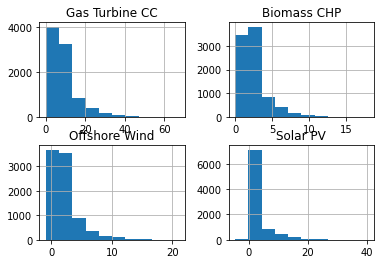

In [ ]:
revenue_hourly.hist()

In [ ]:
# Calculate the yearly revenue of the power producers
revenue_yearly = list(revenue_hourly.sum())       # in 1000 €
revenue_yearly

[64267.0200739548, 22132.51538547582, 19470.994097240786, 19010.71021462604]

#### Cost Calculation

---

In this section, the hourly costs are calculated.

In [ ]:
## Variable Yearly Costs
var_cost_yearly = power_production_yearly*plant_margCost/1000      # in 1000 €
var_cost_yearly

Gas Turbine CC    35065.074993
Biomass CHP        6197.253266
Offshore Wind       662.693714
Solar PV              0.000000
dtype: float64

In [ ]:
## Fixed Yearly Costs
fix_cost_yearly = capacity*plant_fix_opex/(1000)              # yearly costs in 1000 €
fix_cost_yearly

array([3333.33333333, 2877.3006135 , 1878.36363636, 1707.07070707])

#### Financial Matrix


---

In this section, code that adjusts input parameters is compiled. This includes real and nominal price calculations, production scenario calculations as well as depreciation. The financial matrix contains inflation, inflation index and tax rate.

In [ ]:
## Financial Matrix
# Create Matrix that contains financial data
start_year = valuation_year
years = range(start_year,operation_year + lifetime)
financial_mat = pd.DataFrame(data = years, columns = ["year"])
financial_mat["year_count"] = financial_mat["year"] - start_year

# Inflation Adjustment Index - check for which reference real value
financial_mat["inflation"] = inflation
financial_mat["inflation"].iloc[0] = 1
financial_mat["inflation_index"] = financial_mat["inflation"].cumprod()  

# Add the Tax Rate
financial_mat["tax_rate"] = tax_rate

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
financial_mat

,year,year_count,inflation,inflation_index,tax_rate
0,2022,0,1.00,1.000000,0.22
1,2023,1,1.01,1.010000,0.22
2,2024,2,1.01,1.020100,0.22
3,2025,3,1.01,1.030301,0.22
4,2026,4,1.01,1.040604,0.22
5,2027,5,1.01,1.051010,0.22
6,2028,6,1.01,1.061520,0.22
7,2029,7,1.01,1.072135,0.22
8,2030,8,1.01,1.082857,0.22
9,2031,9,1.01,1.093685,0.22


### Technology Selection

---

In this section the technology in question is selected and subsequently, all required data is calculated. 

In [ ]:
# These Technologies are available
print(powerplant_data.columns)

Index(['Gas Turbine CC', 'Biomass CHP', 'Offshore Wind', 'Solar PV'], dtype='object')


In [ ]:
select_plant = 1 - 1        # 0 is the first one

if select_plant > no_technologies:
  print("Technology Selection out of Bounds")
  exit()

### Cost Matrix
---

In this section, the operational costs for the different technologies are calculated. This includes production dependent costs, but also fixed costs based on installed capacity. 

In [ ]:
############ Capital Expenditures
capex = capex                                             # in 1000 €

############ Variable O&M Costs
# Variable Opex
production_opex_var = var_cost_yearly                     # in 1000 €

############ Fixed O&M Costs
# Fixed Opex
production_opex_fix = fix_cost_yearly                     # in 1000 €

In [ ]:
production_opex_var

Gas Turbine CC    35065.074993
Biomass CHP        6197.253266
Offshore Wind       662.693714
Solar PV              0.000000
dtype: float64

In [ ]:
production_opex_fix                      # in 1000 €

array([3333.33333333, 2877.3006135 , 1878.36363636, 1707.07070707])

In [ ]:
revenue_yearly                                # in 1000 €

[64267.0200739548, 22132.51538547582, 19470.994097240786, 19010.71021462604]

### EBITDA

---

In this section, the EBITDA is calculated using the EBITDA-function. 

In [ ]:
scalars = [start_year, select_plant]
vectors = [years, revenue_yearly, production_opex_var, production_opex_fix]
matrices = [financial_mat]

df_analysis = get_EBITDA(start_year, select_plant, years, revenue_yearly,production_opex_var, production_opex_fix,financial_mat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_analysis

,year,year_count,revenue_real,revenue_nom,var_opex_real,var_opex_nom,fix_opex_real,fix_opex_nom,EBITDA
0,2022,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023,1,64267.020074,64909.690275,35065.074993,35415.725743,3333.333333,3366.666667,26127.297865
2,2024,2,64267.020074,65558.787177,35065.074993,35769.883001,3333.333333,3400.333333,26388.570843
3,2025,3,64267.020074,66214.375049,35065.074993,36127.581831,3333.333333,3434.336667,26652.456552
4,2026,4,64267.020074,66876.518800,35065.074993,36488.857649,3333.333333,3468.680033,26918.981117
5,2027,5,64267.020074,67545.283988,35065.074993,36853.746226,3333.333333,3503.366834,27188.170929
6,2028,6,64267.020074,68220.736828,35065.074993,37222.283688,3333.333333,3538.400502,27460.052638
7,2029,7,64267.020074,68902.944196,35065.074993,37594.506525,3333.333333,3573.784507,27734.653164
8,2030,8,64267.020074,69591.973638,35065.074993,37970.451590,3333.333333,3609.522352,28011.999696
9,2031,9,64267.020074,70287.893374,35065.074993,38350.156106,3333.333333,3645.617576,28292.119693


### Depreciation Calculation

---

In [ ]:
## Depreciation
depr_straight_rate = 1/lifetime                           # Straight Line Depreciation Rate
depr_decBalance_rate = 0.15                               # Declining Balance Depreciation Rate

# If Statement to select the depreciation cases 
if depreciation_case == 1:                                                # No Depreciation
  depreciation = np.zeros((calculation_window,1))
elif depreciation_case == 2:                                              # Straight Line
  depreciation = np.zeros((calculation_window,1))
  depreciation[operational_index:] = depr_straight_rate*capex
elif depreciation_case == 3:                                              # Declining Balance
  depreciation = np.zeros((calculation_window,1))
  depreciation[operational_index:] = funcDecliningBalance(capex,lifetime, depr_decBalance_rate)

## Project Analysis

---

This section is used to analyse the projects' financial performance. 

#### Model Base Values

---

This section contains data about financial metrics. 

In [ ]:
# Financial Data
lifetime = 25
tax_rate = 0.22                               # not in percent!
inflation = 1.01                              # not in percent!
valuation_year = 2022                         # year
operation_year = 2023                         # year
calculation_window = operation_year - valuation_year + lifetime
operational_index = operation_year - valuation_year         # Indicates, in which year the operation starts, relative to the valuation year

# Define Financing Parameters
cost_debt = 0.07
cost_equity = 0.07
debt_share_base = 0.60        # Base, since debt_share needs to be adjusted based on the tokeinsation case. 
loan_tenor = 20               # years

if lifetime < loan_tenor:
  print("Loan Tenor exceeds project Lifetime!")
  exit()
if equity_share < 0:
  print("Equity Share too low")
  exit()

# Tokenisation Data
token_share = 0.10
token_price = 0.005                           # not in percent - represents the cost of services of the token platform. 
token_premium = 0.00                          # not in percent - represents the addon on project value of tokenised share.
token_commission = 0.02                       # not in percent - represents the costs of tokenising the asset
token_premium = 0.00

# Select Tokenisation Case
token_case = 1                    # List of [1,2] where 1 (2) is equal to replacing equity (debt)

if token_case != 1 and token_case != 2:
  print("Wrong Token Case")
  exit()

if token_case == 1:
  debt_share_variable = debt_share_base
  equity_share = 1 - debt_share_base - token_share
elif token_case == 2:
  debt_share_variable = debt_share_base - token_share          # Required to enable the second case and iteration
  equity_share = 1 - debt_share_variable - token_share

#### Case Selection

---

This section allows to select between depreciation cases, different operation scenarios (P-50, P-75, P-90) as well as the tokenisation cases.

* Depreciation: No Depreciation (1), Straight-Line (2), Decreasing Balance (3)



In [ ]:
# Production Case - Inverse of Cummulative Density Function
production_case = 50          # Select i.e. P50, P75, P90

# Depreciation case
depreciation_case = 2          # List of [1,2,3]

#### Financial Analysis
---

First, the debtshare, wacc and the discount rate are calculated

In [ ]:
###################################################### Financial Analysis

# Debt Share
debt_share = debt_share_variable
    
# WACC
wacc = equity_share*cost_equity + debt_share*cost_debt*(1-tax_rate)                   # without the token share
#print(wacc)

# Set Discount rate
discount_rate = wacc
discount_rate

0.05376000000000001

The next step is to calculate the tax payments of the projects.

In [ ]:
############################### Financial Tax Analysis
# Initiate Function Arguments
scalars = [start_year,tax_rate]
vectors = [years,depreciation]
matrices = [df_analysis]

# Call the Financial Tax Analysis Function
fin_tax = funcFinAnalysisTax(*scalars,*vectors,*matrices)
fin_tax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,year,year_count,tax_rate,EBITDA,Depreciation,EBIT,Payable Tax
0,2022,0,0.22,0.000000,0.0,0.000000,0.000000
1,2023,1,0.22,26127.297865,4000.0,22127.297865,4868.005530
2,2024,2,0.22,26388.570843,4000.0,22388.570843,4925.485586
3,2025,3,0.22,26652.456552,4000.0,22652.456552,4983.540441
4,2026,4,0.22,26918.981117,4000.0,22918.981117,5042.175846
5,2027,5,0.22,27188.170929,4000.0,23188.170929,5101.397604
6,2028,6,0.22,27460.052638,4000.0,23460.052638,5161.211580
7,2029,7,0.22,27734.653164,4000.0,23734.653164,5221.623696
8,2030,8,0.22,28011.999696,4000.0,24011.999696,5282.639933
9,2031,9,0.22,28292.119693,4000.0,24292.119693,5344.266332


In [ ]:
###################################################### Financial Analysis

results_columns = ["Cost Debt","WACC", "Project IRR", "Project NPV"]

############################### Financial Metrics Analysis
# Initiate Function Arguments
scalars = [start_year, calculation_window, capex, discount_rate, token_commission, token_premium, token_share]
vectors = [years]
matrices = [df_analysis, fin_tax]

# Call the Financial Metrics Analysis Function - Returns the Matrix of Financial Analysis as well as Project Metrics
fin_analysis, fin_output = funcFinAnalysisMetrics(*scalars,*vectors,*matrices)

################################################### Create Results DataFrame
output = pd.DataFrame([[100*cost_debt,100*wacc,fin_output.iloc[0,0], fin_output.iloc[0,1]]], columns=results_columns)

output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Cost Debt,WACC,Project IRR,Project NPV
0,7.0,5.376,22.03,216365.901567


In [ ]:
fin_analysis

,year,year_count,Revenue,Var Opex,Fix Opex,EBITDA,Payable Tax,Investment,Free Cashflows
0,2022,0,0.000000,0.000000,0.000000,0.000000,0.000000,100000.0,-100000.000000
1,2023,1,64909.690275,35415.725743,3366.666667,26127.297865,4868.005530,0.0,21259.292335
2,2024,2,65558.787177,35769.883001,3400.333333,26388.570843,4925.485586,0.0,21463.085258
3,2025,3,66214.375049,36127.581831,3434.336667,26652.456552,4983.540441,0.0,21668.916110
4,2026,4,66876.518800,36488.857649,3468.680033,26918.981117,5042.175846,0.0,21876.805272
5,2027,5,67545.283988,36853.746226,3503.366834,27188.170929,5101.397604,0.0,22086.773324
6,2028,6,68220.736828,37222.283688,3538.400502,27460.052638,5161.211580,0.0,22298.841057
7,2029,7,68902.944196,37594.506525,3573.784507,27734.653164,5221.623696,0.0,22513.029468
8,2030,8,69591.973638,37970.451590,3609.522352,28011.999696,5282.639933,0.0,22729.359763
9,2031,9,70287.893374,38350.156106,3645.617576,28292.119693,5344.266332,0.0,22947.853360


## Monte Carlo Simulation
--- 

In this section, the Monte Carlo Simulation is performed. 

### Model Inputs

---


In [ ]:
########################################################################
################################# Technology Selection

# These Technologies are available
print(powerplant_data.columns)

Index(['Gas Turbine CC', 'Biomass CHP', 'Offshore Wind', 'Solar PV'], dtype='object')


In [ ]:
select_plant = 3 - 1        # 0 is the first one

if select_plant > no_technologies:
  print("Technology Selection out of Bounds")
  exit()


# Plant Sizing
total_available_capital = 400                # in M€ 

capex = total_available_capital/no_technologies      # Available capital for each technology

In [ ]:
########################################################################
################################# Price Adjustment
mean_adjustment = 40
################################# Define financing parameters

# Define Financing Parameters
cost_debt = 0.03
cost_equity = 0.07
debt_share_base = 0.60       # Base, since debt_share needs to be adjusted based on the tokeinsation case. 
loan_tenor = 20               # years

if lifetime < loan_tenor:
  print("Loan Tenor exceeds project Lifetime!")
  exit()
if equity_share < 0:
  print("Equity Share too low")
  exit()

    
# Define Tokenisation Parameters
token_share = 0.0
token_price = 0.005                           # not in percent - represents the cost of services of the token platform. 
token_premium = 0.00                          # not in percent - represents the addon on project value of tokenised share.
token_commission = 0.02                       # not in percent - represents the costs of tokenising the asset
token_premium = 0.00

# Select Tokenisation Case
token_case = 1                    # List of [1,2] where 1 (2) is equal to replacing equity (debt)

if token_case != 1 and token_case != 2:
  print("Wrong Token Case")
  exit()

if token_case == 1:
  debt_share_variable = debt_share_base
  equity_share = 1 - debt_share_base - token_share
elif token_case == 2:
  debt_share_variable = debt_share_base - token_share          # Required to enable the second case and iteration
  equity_share = 1 - debt_share_variable - token_share


################################ Cost of Capital
# Debt Share
debt_share = debt_share_variable
      
# WACC
wacc = equity_share*cost_equity + debt_share*cost_debt*(1-tax_rate)                   # without the token share
#print(wacc)

# Set Iterations
n_iter = 7

# Set Prices
mean_price = 50.80    # €/MWh
#mean_price = 50.80   # €/MWh
mean_std = mean_price*0.89
#mean_std = 13.32

### 1. Model: Project Return

---

In [ ]:
%%capture
results_columns = ["Cost Debt","WACC", "Project IRR", "Project NPV"]
fin_results = pd.DataFrame(data = [] ,columns=results_columns)
margCost_results = pd.DataFrame(data = [], columns = powerplant_data.columns)
capacity_results = pd.DataFrame(data = [], columns = powerplant_data.columns)

# Set the discount rate
discount_rate = wacc



for i in range(n_iter):
  ########################################################################
  #################################### Stochastic Prices

  # Power Prices
  price_stats = el_prices.describe()                      # Obtains Statistical Values from prices
  std_percentage = mean_std/mean_price
  el_price_stoch_hourly = pd.DataFrame(np.random.normal(mean_price,mean_price*std_percentage, size = (8760,1)))       # Develop a dataframe with stochastic prices

  # Plant Data
  cap_stoch = list(np.random.normal(plant_spec_capex, np.array(plant_spec_capex)*np.array(stdev_values.iloc[0,:])))
  fixopex_stoch = list(np.random.normal(plant_fix_opex, np.array(plant_fix_opex)*np.array(stdev_values.iloc[1,:])))
  varopex_stoch = list(np.random.normal(plant_var_opex, np.array(plant_var_opex)*np.array(stdev_values.iloc[2,:])))

  # Carbon Price
  carbon_stdev_ratio = stdev_values.iloc[3,0]/carbon_price_base
  carbon_price_stoch = np.random.normal(carbon_price_base, carbon_stdev_ratio*carbon_price_base)


  # Marginal costs
  plant_margCost = list(np.array(plant_fuel_cost)*np.array(plant_energy_conversion) + carbon_price_stoch*np.array(plant_carbon_intensity)*np.array(plant_energy_conversion) + np.array(varopex_stoch))


  ####################### Plant Sizing
  capacity_stoch = capex*np.reciprocal(cap_stoch)     # Installed Capacities of plants are determined in MW
  

  ########################################################################
  ################################### Production Schedule
  # Obtain Technology Names
  column_names = powerplant_data.columns.to_list()
  column_names

  ### Capacity Factors of Non-Dispatchables
  production_cf = pd.DataFrame(np.ones((len(el_price_stoch_hourly),2)), columns = ["gas_cf", "bio_cf"])    # to dispatchable plants
  production_cf = pd.concat([production_cf, capacity_factors[["wind_cf", "solar_cf"]]], axis = 1)
  production_cf.head

  ## Create an adaptive dataframe with 0s that represents the production_cycle
  production_cycle = pd.DataFrame(np.ones((el_price_stoch_hourly.shape[0], no_dispatchables)), columns = column_names[:no_dispatchables])
  production_cycle = production_cycle.mul(plant_margCost[:no_dispatchables])

  # Production Schedule
  for i in range(len(production_cycle)):

    # Move between columns
    for j in range(no_dispatchables):
    
      if (production_cycle.iloc[i,j] > el_price_stoch_hourly.iloc[i,0]):
        production_cycle.iloc[i,j] = 0
      else:
        production_cycle.iloc[i,j] = 1

  production_cycle = pd.concat([production_cycle, pd.DataFrame(np.ones((el_price_stoch_hourly.shape[0], no_nondispatchables)), columns = column_names[no_dispatchables:])], axis = 1)


  ########################################################################
  ##################################### Hourly and Yearly Production

  ###### Hourly
  # Calculate the hourly production based on the capacity factor, the capacity and the production cycle based on marginal and electricity prices. 
  production_hourly = pd.DataFrame(np.multiply(np.array(production_cf),(np.array(production_cycle))), columns = column_names)*capacity_stoch

  # Calculate the yearly production of each power plant.
  production_yearly = list(production_hourly.sum())


  ################### P50 Cases
  # Set the relative standard deviation
  rel_std = 0.10 

  ############# Calculation of Hourly Power Production depending on case
  power_production_hourly = production_hourly
  power_production_hourly[["Offshore Wind", "Solar PV"]] = norm.ppf(1-production_case/100, loc=production_hourly[["Offshore Wind", "Solar PV"]], scale=production_hourly[["Offshore Wind", "Solar PV"]]*rel_std)
  power_production_hourly = power_production_hourly.fillna(0)
  power_production_hourly.describe()

  # Calculation of Yearly Power Production depending on case
  power_production_yearly = power_production_hourly.sum()       # MWh



  ########################################################################
  ################################# Revenue Calculation

  ######## Hourly Revenue
  revenue_hourly = power_production_hourly.to_numpy()*el_price_stoch_hourly.to_numpy()
  revenue_hourly = pd.DataFrame(revenue_hourly, columns = power_production_hourly.columns)/1000       # in 1000 €
  revenue_hourly           # in 1000 €

  ######## Calculate the yearly revenue of the power producers
  revenue_yearly = list(revenue_hourly.sum())       # in 1000 €
  

  ########################################################################
  ################################# Cost Calculation

  ## Variable Yearly Costs
  var_cost_yearly = power_production_yearly*plant_margCost/1000      # in 1000 €
  

  ## Fixed Yearly Costs
  fix_cost_yearly = capacity_stoch*fixopex_stoch/(1000)              # yearly costs in 1000 €
  


  ########################################################################
  ################################# Financial Matrix that contains inflation and tax, etc.

  # Create Matrix that contains financial data
  start_year = valuation_year
  years = range(start_year,operation_year + lifetime)
  financial_mat = pd.DataFrame(data = years, columns = ["year"])
  financial_mat["year_count"] = financial_mat["year"] - start_year

  # Inflation Adjustment Index - check for which reference real value
  financial_mat["inflation"] = inflation
  financial_mat["inflation"].iloc[0] = 1
  financial_mat["inflation_index"] = financial_mat["inflation"].cumprod()  

  # Add the Tax Rate
  financial_mat["tax_rate"] = tax_rate

  ########################################################################
  ################################# Cost Matrix for Financial Analysis

  ############ Capital Expenditures
  capex_iter = capex*1000                                             # in 1000 €

  ############ Variable O&M Costs
  # Variable Opex
  production_opex_var = var_cost_yearly                     # in 1000 €

  ############ Fixed O&M Costs
  # Fixed Opex
  production_opex_fix = fix_cost_yearly                     # in 1000 €



  ########################################################################
  ################################# Price Matrix & EBITDA
  scalars = [start_year, select_plant]
  vectors = [years, revenue_yearly, production_opex_var, production_opex_fix]
  matrices = [financial_mat]

  df_analysis = get_EBITDA(start_year, select_plant, years, revenue_yearly,production_opex_var, production_opex_fix,financial_mat)
  


  ########################################################################
  ############################### Financial Tax Analysis
  # Initiate Function Arguments
  scalars = [start_year,tax_rate]
  vectors = [years,depreciation]
  matrices = [df_analysis]

  # Call the Financial Tax Analysis Function
  fin_tax = funcFinAnalysisTax(*scalars,*vectors,*matrices)

  ########################################################################
  ##############################Financial Analysis

  ############################### Financial Metrics Analysis
  # Initiate Function Arguments
  scalars = [start_year, calculation_window, capex_iter, discount_rate, token_commission, token_premium, token_share]
  vectors = [years]
  matrices = [df_analysis, fin_tax]

  # Call the Financial Metrics Analysis Function - Returns the Matrix of Financial Analysis as well as Project Metrics
  fin_analysis, fin_output = funcFinAnalysisMetrics(*scalars,*vectors,*matrices)

  ################################################### Create Results DataFrame
  output = pd.DataFrame([[100*cost_debt,100*wacc,fin_output.iloc[0,0], fin_output.iloc[0,1]]], columns=results_columns)
  fin_results = fin_results.append(output)


  ## Marginal Costs
  plant_margCost = pd.DataFrame([plant_margCost], columns = powerplant_data.columns)
  margCost_results = margCost_results.append(plant_margCost)

  ## Capacity
  capacity = pd.DataFrame([capacity_stoch], columns = powerplant_data.columns)
  capacity_results = capacity_results.append(capacity)

  print(i)

In [ ]:
print(debt_share)
print(equity_share)
print(cost_debt)
print(cost_equity)

0.6
0.4
0.03
0.07


In [ ]:
fin_results

,Cost Debt,WACC,Project IRR,Project NPV
0,3.0,4.204,5.82,18390.285797
0,3.0,4.204,7.08,33746.206282
0,3.0,4.204,6.23,23266.070538
0,3.0,4.204,6.16,22468.922197
0,3.0,4.204,5.72,17133.559891
0,3.0,4.204,6.10,21683.169118
0,3.0,4.204,6.51,26615.303779


In [ ]:
fin_analysis

,year,year_count,Revenue,Var Opex,Fix Opex,EBITDA,Payable Tax,Investment,Free Cashflows
0,2022,0,0.000000,0.000000,0.000000,0.000000,0.000000,100000.0,-100000.000000
1,2023,1,11090.953220,652.838178,1861.027642,8577.087401,1006.959228,0.0,7570.128173
2,2024,2,11201.862753,659.366559,1879.637918,8662.858275,1025.828820,0.0,7637.029454
3,2025,3,11313.881380,665.960225,1898.434298,8749.486858,1044.887109,0.0,7704.599749
4,2026,4,11427.020194,672.619827,1917.418641,8836.981726,1064.135980,0.0,7772.845746
5,2027,5,11541.290396,679.346025,1936.592827,8925.351543,1083.577340,0.0,7841.774204
6,2028,6,11656.703300,686.139486,1955.958755,9014.605059,1103.213113,0.0,7911.391946
7,2029,7,11773.270333,693.000881,1975.518343,9104.751109,1123.045244,0.0,7981.705865
8,2030,8,11891.003036,699.930889,1995.273526,9195.798621,1143.075697,0.0,8052.722924
9,2031,9,12009.913067,706.930198,2015.226261,9287.756607,1163.306453,0.0,8124.450153


In [ ]:
margCost_results

,Gas Turbine CC,Biomass CHP,Offshore Wind,Solar PV
0,71.059795,25.567513,3.134251,0.0
0,63.955094,26.611264,3.102684,0.0
0,71.181951,26.546767,3.090228,0.0
0,67.988940,26.017135,3.410003,0.0
0,68.789586,27.448254,3.213576,0.0
0,64.567566,26.254851,3.003981,0.0
0,66.923057,26.344650,3.003353,0.0


In [ ]:
capacity_results

,Gas Turbine CC,Biomass CHP,Offshore Wind,Solar PV
0,122.218949,25.860593,43.798389,272.498414
0,96.901772,30.738732,49.397926,215.594245
0,126.751817,31.023904,44.666053,238.878674
0,105.045318,26.643993,45.745568,252.765980
0,104.670178,29.067361,44.047099,216.024147
0,95.868473,27.300939,43.625222,235.310686
0,99.134587,29.180039,45.684202,240.211021
